In [12]:
import networkx as nx

from pathlib import Path

from hloc import extract_features, match_features
from hloc import pairs_from_retrieval, localize_sfm, visualization
from hloc.utils import viz_3d
import pycolmap
import numpy as np

In [13]:
# Setup the paths
base_dir = Path('/cluster/project/infk/courses/252-0579-00L/group07')

images = base_dir / 'datasets' / 'images'
models = base_dir / 'outputs' / 'models-features'
merge = base_dir / 'outputs' / 'test' / 'merge'
outputs = base_dir / 'outputs' / 'test' / 'graph'

outputs.mkdir(exist_ok=True, parents=True)


In [14]:
def model_path_2_name(model_path:str):
    return str(model_path).replace("/","__")


def model_name_2_path(model_path):
    return Path(str(model_path).replace("__","/"))
    # Recursively search for all models
    

In [15]:
model_folders = [p.parent for p in Path(models).glob("**/images.bin")]

remove_folders = []
for model_folder in model_folders:
    
    # If we have reconstructions in the PATH/models/[0-9] folders
    # Then we should remove the reconstruction in PATH, as this reconstruction
    # is the same as one of the ones in PATH/models/[0-9]
    if model_folder.name.isdigit():    
        rem_folder = model_folder.relative_to(models)
        remove_folders.append(rem_folder)

# Make the model_folder paths relative to models_dir and remove redundant folders
model_folders = [model_folder.relative_to(models) for model_folder in model_folders if model_folder not in remove_folders]


In [16]:
model_folders

model_names = ["__".join(model_f.parts[:2]) for model_f in model_folders]
model_names

['2obsKLoZQdU__part0',
 '2obsKLoZQdU__part10',
 '2obsKLoZQdU__part11',
 '2obsKLoZQdU__part12',
 '2obsKLoZQdU__part13',
 '2obsKLoZQdU__part14',
 '2obsKLoZQdU__part15',
 '2obsKLoZQdU__part16',
 '2obsKLoZQdU__part17',
 '2obsKLoZQdU__part18',
 '2obsKLoZQdU__part19',
 '2obsKLoZQdU__part19',
 '2obsKLoZQdU__part1',
 '2obsKLoZQdU__part20',
 '2obsKLoZQdU__part21',
 '2obsKLoZQdU__part21',
 '2obsKLoZQdU__part21',
 '2obsKLoZQdU__part22',
 '2obsKLoZQdU__part23',
 '2obsKLoZQdU__part24',
 '2obsKLoZQdU__part25',
 '2obsKLoZQdU__part26',
 '2obsKLoZQdU__part27',
 '2obsKLoZQdU__part28',
 '2obsKLoZQdU__part2',
 '2obsKLoZQdU__part3',
 '2obsKLoZQdU__part4',
 '2obsKLoZQdU__part5',
 '2obsKLoZQdU__part6',
 '2obsKLoZQdU__part7',
 '2obsKLoZQdU__part8',
 '2obsKLoZQdU__part9']

In [17]:
model_transforms = [p for p in Path(merge).glob("**/trans_*")]
# model_transform_names = [p.name for p in model_transforms]

def load_transform(tf_path):
    with open(tf_path, "r") as f:
        tf = pycolmap.SimilarityTransform3(np.loadtxt(f,delimiter=",")).inverse()
    return tf

transform_edges = []


def parse_merge_name(tf_path):
    tf_name = tf_path.name

    suffix=".txt"
    if tf_name.endswith(suffix):
        tf_name = tf_name[:-len(suffix)]

    s =  tf_name.split("__")[1:]
    if len(s) == 2:
        name1, name2 = s
    
    elif len(s) == 4:
        # vid1, p1, vid2, p2 = s
        name1 = "__".join(s[:2])
        name2 = "__".join(s[2:])

    elif len(s) == 5:
        if "model" in s[2]:
            #vid1, p1, m1, vid2, p2 = s
            name1 = "__".join(s[:3])
            name2 = "__".join(s[3:])
        elif "model" in s[-1]:
            #vid1, p1, vid2, p2, m2 = s
            name1 = "__".join(s[:2])
            name2 = "__".join(s[2:])
    else:
        return None
    return (name1, name2), load_transform(tf_path)

transform_edges = [parse_merge_name(tf_name) for tf_name in model_transforms]
transform_edges = [te for te in transform_edges if te is not None]
transform_edges



[(('2obsKLoZQdU__part17', '2obsKLoZQdU__part18'),
  SimilarityTransform3:
    0.923998  -0.115715  -0.458583   0.593712
   0.0802179    1.03022 -0.0983259    1.16875
    0.466104  0.0520867    0.92601    10.7944
           0          0          0          1),
 (('2obsKLoZQdU__part16', '2obsKLoZQdU__part17'),
  SimilarityTransform3:
    -0.94779  0.0493964   0.333525    3.91196
  0.00696485   0.997776  -0.127982  -0.291615
   -0.337091  -0.118271  -0.940408    3.24701
           0          0          0          1),
 (('2obsKLoZQdU__part15', '2obsKLoZQdU__part16'),
  SimilarityTransform3:
      1.10376   -0.185649 -0.00140714    0.876636
     0.183594     1.09274   -0.158026   -0.525097
    0.0275851    0.155606     1.10805     3.02284
            0           0           0           1)]

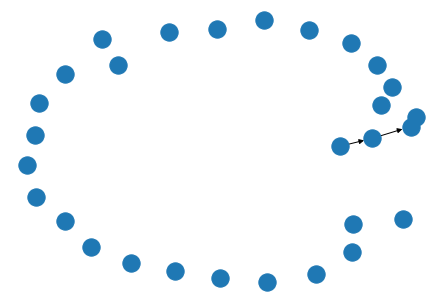

In [18]:
G = nx.DiGraph()
for name, folder in zip(model_names, model_folders):
    G.add_node(name, model=folder)

for (tf_u, tf_v), tf in transform_edges:
    G.add_edge(tf_u, tf_v, transform=tf)

#G.add_nodes_from(model_names)
#G.add_edges_from(transform_edges, tf="trans")

nx.draw(G)


In [19]:
def rand_color():
        return f'rgba({np.random.randint(0,256)},{np.random.randint(42,98)},{np.random.randint(40,90)},0.2)'


# Set this to the first node in the chain!
base_node = '2obsKLoZQdU__part15'

fig = viz_3d.init_figure()
b = pycolmap.Reconstruction(models / G.nodes[base_node]["model"])
viz_3d.plot_reconstruction(fig, b, color=rand_color(), name=base_node, points=False, cs=0.2)
b.export_PLY(outputs/ f"{base_node}.ply")
for parent, child, _ in nx.edge_bfs(G, base_node, orientation='original'):
    
    m = pycolmap.Reconstruction(models / G.nodes[child]["model"])
    m.transform(G[parent][child]['transform'])
    
    for reverse_parent, reverse_child, _ in nx.edge_bfs(G, parent, orientation='reverse'):

            m.transform(G[reverse_parent][reverse_child]['transform'])

    viz_3d.plot_reconstruction(fig, m, color=rand_color(), name=child, points=False, cs=0.2)
    m.export_PLY(outputs/ f"{child}.ply")

In [20]:
fig.show()